# **Install**

In [5]:
!pip install category_encoders

In [6]:
pip install catboost

# **Import**

In [7]:
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
import numpy as np
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error
from catboost import CatBoostClassifier, CatBoostRegressor

from tqdm import tqdm_notebook
# Dependencies


import category_encoders as ce   
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
path = '/content/'
df=pd.read_csv(path + 'Train (19).csv')

#   This is the submission file result from the Other notebook 
sub=pd.read_csv(path+'ss_idag.csv')


sub['year']=0
sub['month']=0
sub['product_code']=0
sub['site_code']=0
sub['stock_distributed']=sub['prediction']

for i in range (len(sub)):
     
     sub['year'][i]=(str(sub['ID'][i]).split(' X '))[0]
     sub['month'][i]=(str(sub['ID'][i]).split(' X '))[1]
     sub['site_code'][i]=(str(sub['ID'][i]).split(' X '))[2]
     sub['product_code'][i]=(str(sub['ID'][i]).split(' X '))[3]
sub.head()

,ID,prediction,year,month,product_code,site_code,stock_distributed
0,2019 X 7 X C4001 X AS21126,0.456293,2019,7,AS21126,C4001,0.456293
1,2019 X 7 X C4001 X AS27134,19.944806,2019,7,AS27134,C4001,19.944806
2,2019 X 7 X C4001 X AS27132,0.494013,2019,7,AS27132,C4001,0.494013
3,2019 X 7 X C4001 X AS27000,11.935948,2019,7,AS27000,C4001,11.935948
4,2019 X 7 X C4001 X AS27137,2.509583,2019,7,AS27137,C4001,2.509583


In [9]:
ss=pd.read_csv(path+'SampleSubmission (20).csv')


In [10]:
serv=pd.read_csv(path + 'service_delivery_site_data.csv')
train=pd.merge(df,serv, on='site_code',how='left')
test=pd.merge(sub,serv, on='site_code',how='left')
train.drop(columns=['region','district'],inplace=True)
product=pd.read_csv(path + 'product.csv')
prodclass=['Condom','Condom','oral','Implant','Implant','Injectable','Injectable','Injectable','uid','oral','oral']
emergency=[0,0,1,0,0,0,0,0,0,0,0]
genderprod=[0,1,0,0,0,1,1,1,0,0,0]
product['class']=prodclass
product['gender']=genderprod
product['is_emergency'] = emergency

train=pd.merge(train,product, on='product_code',how='left')
test=pd.merge(test,product, on='product_code',how='left')

In [11]:
train = train.reset_index(drop = True)

In [12]:
train.shape

(35753, 22)

In [13]:
def check_valid_data(x):
    return (x.stock_initial==x.stock_end.shift(1)) | (x.stock_received == x.stock_end.shift(1)) | (x.stock_distributed == x.stock_end.shift(1))
train = train.sort_values(by = ['site_code', 'product_code', 'year', 'month']).reset_index(drop = True)
train = train.groupby(['site_code', 'product_code']).apply(lambda x: x[check_valid_data(x)]).reset_index(drop = True)

In [14]:
train.shape

(34246, 22)

In [15]:
mcase=pd.read_csv(path + 'monthly_cases.csv')
acase=pd.read_csv(path + 'annual_cases.csv')

In [16]:
m=pd.DataFrame()
for i in mcase.drop(columns=['district','year','month']):     
     m[str(i)] = mcase.groupby(['year', 'district'])[i].transform('sum')
mcols = m.columns
for i in mcase.drop(columns=['district','year','month']):   
     m[str(i) + '_mean'] = mcase.groupby(['year', 'district'])[i].transform('mean')
     m[str(i)] = mcase.groupby(['year', 'district'])[i].transform('std')

In [17]:
m['district']=mcase['district']
m['year']=2019
a=acase[mcols]

In [18]:
help=a.append(m)
help['site_district']=help['district']
help.drop(columns=['district'],inplace=True)
help= help.drop(['injection2_stock_end','iud_stock_end',],1)

In [19]:
def assignpop(train):
      train['population']=0
      train.loc[train.site_district=='ABENGOUROU','population']=104020
      train.loc[train.site_district=='ABOBO-EST','population']=900000
      train.loc[train.site_district=='Aboisso','population']=37654
      train.loc[train.site_district=='ADJAME-PLATEAU-ATTECOUBE','population']=300000
      train.loc[train.site_district=='ADZOPE','population']=98460
      train.loc[train.site_district=='AGBOVILLE','population']=81870
      train.loc[train.site_district=='AGNIBILEKROU','population']=43601
      train.loc[train.site_district=='AKOUPE','population']=35970

      train.loc[train.site_district=='ALEPE','population']=40470
      train.loc[train.site_district=='ANYAMA','population']=100653
      train.loc[train.site_district=='BANGOLO','population']=17712
      train.loc[train.site_district=='BEOUMT','population']=23053
      train.loc[train.site_district=='BETTIE','population']=24983
      train.loc[train.site_district=='BIANKOUMA','population']=22870
      train.loc[train.site_district=='BLOLEQUIN','population']=71854
      train.loc[train.site_district=='BOACANDA','population']=105000


      train.loc[train.site_district=='BONDOUKOU','population']=58297
      train.loc[train.site_district=='BONGOUANOU','population']=34405
      train.loc[train.site_district=='BOUAFLE','population']=60962
      train.loc[train.site_district=='BOUAKE NORD-OUEST','population']=567481
      train.loc[train.site_district=='BOUNA','population']=23570
      train.loc[train.site_district=='BOUNDIALI','population']=38870
      train.loc[train.site_district=='COCODY-BINGERVILLE','population']=91319
      train.loc[train.site_district=='DABAKALA','population']=55769


      train.loc[train.site_district=='DABOU','population']=69661
      train.loc[train.site_district=='DALOA','population']=215652
      train.loc[train.site_district=='DANANE','population']=53808
      train.loc[train.site_district=='DAOUKRO NORD-OUEST','population']=40175
      train.loc[train.site_district=='DIDIEVI','population']=22519
      train.loc[train.site_district=='DIMBOKRO','population']=67349
      train.loc[train.site_district=='DIVO','population']=128767
      train.loc[train.site_district=='DUEKOUE','population']=47198


      train.loc[train.site_district=='FERKESSEDOUGOU','population']=62008
      train.loc[train.site_district=='FRESCO','population']=41058
      train.loc[train.site_district=='GAGNOA','population']=123184
      train.loc[train.site_district=='GRAND-BASSAM','population']=73772
      train.loc[train.site_district=='GRAND-LAHOU','population']=67483
      train.loc[train.site_district=='GUEYO','population']=3859
      train.loc[train.site_district=='GUIGLO','population']=39134
      train.loc[train.site_district=='ISSIA','population']=50313



      train.loc[train.site_district=='JACQUEVILLE','population']=32228
      train.loc[train.site_district=='KATIOLA','population']=59641
      train.loc[train.site_district=='KORHOGO','population']=167359
      train.loc[train.site_district=='KOUIBLY','population']=43392
      train.loc[train.site_district=='KOUMASSI-PORT BOUET-VRIDI','population']=317562
      train.loc[train.site_district=='LAKOTA','population']=38055
      train.loc[train.site_district=='MAN','population']=139342
      train.loc[train.site_district=='MANKONO','population']=19313



      train.loc[train.site_district=="M'BAHIAKRO",'population']=79768
      train.loc[train.site_district=='MINIGNAN','population']=14521
      train.loc[train.site_district=='NASSIAN','population']=19971
      train.loc[train.site_district=='NIAKARAMADOUGOU','population']=49824
      train.loc[train.site_district=='ODIENNE','population']=49857
      train.loc[train.site_district=='OUANGOLO','population']=100
      train.loc[train.site_district=='OUME','population']=52070
      train.loc[train.site_district=='PRIKRO','population']=33242



      train.loc[train.site_district=="SAKASSOU",'population']=15068
      train.loc[train.site_district=='SAN PEDRO','population']=196751
      train.loc[train.site_district=='SASSANDRA','population']=23274
      train.loc[train.site_district=='SEGUELA','population']=51157
      train.loc[train.site_district=='SIKENSI','population']=78439
      train.loc[train.site_district=='SINFRA','population']=59919
      train.loc[train.site_district=='SOUBRE','population']=175163
      train.loc[train.site_district=='TABOU','population']=17134



      train.loc[train.site_district=="TANDA",'population']=20161
      train.loc[train.site_district=='TENGRELA','population']=39277
      train.loc[train.site_district=='TIASSALE','population']=35090
      train.loc[train.site_district=='TIEBISSOU','population']=15501
      train.loc[train.site_district=='TOUBA','population']=27504
      train.loc[train.site_district=='TOULEPLEU','population']=21700
      train.loc[train.site_district=='TOUMODI','population']=39005
      train.loc[train.site_district=='TREICHVILLE-MARCORY','population']=500000


      train.loc[train.site_district=='VAVOUA','population']=31250
      train.loc[train.site_district=='YAMOUSSOUKRO','population']=194530
      train.loc[train.site_district=='YOPOUGON-EST','population']=600000
      train.loc[train.site_district=='YOPOUGON-OUEST-SONGON','population']=600000
      train.loc[train.site_district=='ZOUAN-HOUNIEN','population']=92943
      train.loc[train.site_district=='GUITRY','population']=260

      train.loc[train.site_district=='ZUENOULA','population']=34335
      return(train)

In [20]:
%%time
train=assignpop(train)
test=assignpop(test)
test.loc[test.site_district=='KORO','population']=63120

CPU times: user 477 ms, sys: 2.99 ms, total: 480 ms
Wall time: 480 ms


In [21]:
listeofdata=[]
for i in tqdm_notebook(test['site_code'].unique()):
  for j in test.loc[test.site_code==i]['product_code'].unique():
     x=train.loc[(train['site_code']==i)&(train['product_code']==j)]
     x['stock_distributed'] = x['stock_distributed']# + np.random.normal(scale=2, size=len(x))
     y=test.loc[(test['site_code']==i)&(test['product_code']==j)]
     x=x.append(y)
     listeofdata.append(x)
     
splitdatas=[]
for i in tqdm_notebook(range(len(listeofdata))):
     splitdatas.append(listeofdata[i].sort_values(by = ['year', 'month']))

print('---------------------SHIFT---------------------')
for i in tqdm_notebook(splitdatas) :
  
  i['target-1']=i['stock_distributed'].shift(1)
  i['target-2']=i['stock_distributed'].shift(2)
  
  i['target-3']=i['stock_distributed'].shift(3)
  
  i['target-4']=i['stock_distributed'].shift(4)

  i['target-5']=i['stock_distributed'].shift(5)

  i['target-6']=i['stock_distributed'].shift(6)




---------------------SHIFT---------------------


In [22]:
df=pd.DataFrame()
for i in splitdatas:
  df=df.append(i)

# **External Data** 

---
[External Data Links](https://docs.google.com/document/d/165r8uhgXhtwsEtVgv2-rGOPnzDaxArXZn8SsnaDZYtI/edit?usp=sharing)



In [23]:
def get_fertility_per_year(df) :
  df['fert']=0
  df.loc[df.year==2019,'fert']=4.60
  df.loc[df.year==2018,'fert']=4.65
  df.loc[df.year==2017,'fert']=4.71
  df.loc[df.year==2016,'fert']=4.76
  return df

In [24]:
df = get_fertility_per_year(df)

In [25]:
def get_density_per_year(df) :
  df['densité']=0
  df.loc[df.year==2019,'densité']=81
  df.loc[df.year==2018,'densité']=79
  df.loc[df.year==2017,'densité']=77
  df.loc[df.year==2016,'densité']=75
  return df

In [26]:
# df = get_density_per_year(df)

In [27]:
def get_regions_stats(df) :
    columns = ['HOMMES' 'FEMMES' 'TOTAL' 'RM' 'NOMBRE' 'TAILLE' 'MOYENNE']

    map_regions = {}

    map_regions['INDENIE-DJUABLIN'] = [290211,270221 ,560432,107.4,104620,5.4]
    map_regions['ABIDJAN 1-GRANDS PONTS'] = [772989,705058 ,1478047, 109.6, 275583, 5.4]
    map_regions['ABIDJAN 2'] = [2337581 ,2369823, 4707404, 98.6, 1016386 ,4.6]
    map_regions['SUD-COMOE'] = [326182 ,316438, 642620, 103.1 ,122153, 5.3]
    map_regions['AGNEBY-TIASSA-ME'] = [320380 ,286472,606852, 111.8 ,119531 ,5.1]
    map_regions['CAVALLY-GUEMON'] = [375775.0, 313903.0, 689678.0, 121.35, 130550.0, 5.15]
    map_regions['GBEKE'] = [506612 ,504237 ,1010849, 100.5 ,170716, 5.9]
    map_regions['TONKPI'] = [526181 ,466383 ,992564 ,112.8, 203081 ,4.9]
    map_regions["N'ZI-IFOU-MORONOU"] = [633031 ,625573 ,1258604, 101.2 ,200815, 6.3]
    map_regions['BOUNKANI-GONTOUGO'] = [471322 ,463030, 934352, 101.8 ,195170 ,4.8]
    map_regions['MARAHOUE'] = [457147, 405197, 862344 ,112.8 ,139021 ,6.2]

    map_regions['PORO-TCHOLOGO-BAGOUE'] = [812540, 794957, 1607497 ,102.2 ,248175 ,6.5]
    map_regions['HAMBOL'] = [219154 ,210823 ,429977 ,104.0, 73167 ,5.9]
    map_regions['HAUT-SASSANDRA'] = [772895 ,658065, 1430960 ,117.4 ,229411 ,6.2]

    map_regions['BELIER'] = [172552, 174216 ,346768 ,99.0 ,59599, 5.8]
    map_regions['LOH-DJIBOUA'] = [383783 ,345386 ,729169 ,111.1 ,123198 ,5.9]
    map_regions['GOH'] = [461813, 414304, 876117 ,111.5 ,151046, 5.8]

    map_regions['GBOKLE-NAWA-SAN PEDRO'] = [1214422 ,1066126, 2280548 ,113.9 ,420072, 5.4]
    map_regions['WORODOUGOU-BERE'] = [173062.0, 157984.0, 331046.0, 110.05, 50879.5, 6.5]
    map_regions['KABADOUGOU-BAFING-FOLON'] = [81069.0,76539.6,157608.6,105.36,21628.6,7.9]
    map=map_regions
    map_final = {}
    map_final['site_region'] = list(map.keys())
    map_final['HOMMES'] = [map[x][0] for x in map.keys() ]
    map_final['FEMMES'] = [map[x][1] for x in map.keys() ]
    map_final['TOTAL'] = [map[x][2] for x in map.keys() ]
    map_final['RM'] = [map[x][3] for x in map.keys() ]
    map_final['NOMBRE'] = [map[x][4] for x in map.keys() ]
    map_final['TAILLE_MOYENNE'] = [map[x][5] for x in map.keys() ]
    mapf=pd.DataFrame(map_final)

    df = pd.merge(df,mapf,how='left',on='site_region')
    return df

In [28]:
def get_districts_stats(df) :
    Columns = ['District','HOMMES', 'FEMMES' ,'TOTAL', 'RM' ,'NOMBRE' ,'TAILLE_MOYENNE']

    map = {}
    map['ABENGOUROU'] = [173940 ,162208, 336148 ,107.2 ,63549 ,5.3]
    map['ABOISSO'] = [158430, 149422, 307852, 106.0, 55309, 5.6]
    map['ADIAKE'] = [42882 ,40665 ,83547 ,105.5 ,16402 ,5.1]
    map['ADJAME-PLATEAU-ATTECOUBE'] = [330849, 310528, 641377, 101.9, 135885, 4.7]
    map['ADZOPE'] = [99871 ,93647 ,193518, 106.6 ,36134 ,5.4]
    map['AGBOVILLE'] = [150957 ,141152 ,292109 ,106.9 ,56032, 5.2]
    map['AGNIBILEKROU'] = [86921 ,81267 ,168188 ,107.0 ,32102 ,5.2]
    map['AKOUPE'] = [61422 ,57606 ,119028, 106.6 ,22567 ,5.3]
    map['ALEPE'] = [65830 ,60047 ,125877, 109.6, 21110 ,6.0]
    map['ANYAMA'] = [75882, 73080, 148962, 103.8, 29633, 5.0]
    map['BANGOLO'] = [174120 ,144009 ,318129,120.9 ,60983 ,5.2]
    map['BEOUMI'] = [77168, 77038, 154206 ,100.2 ,25623 ,6.0]
    map['BETTIE'] = [29350 ,26746, 56096 ,109.7 ,8969, 6.3]
    map['BIANKOUMA'] = [85130, 69170 ,154300, 123.1, 35959 ,4.3]
    map['BLOLEQUIN'] = [72934, 50402 ,123336 ,144.7 ,28283 ,4.4]
    map['BOCANDA'] = [62264, 64646 ,126910, 96.3, 17181 ,7.4]
    map['BONDOUKOU'] = [169168 ,164539, 333707, 102.8, 75899 ,4.4]
    map['BONGOUANOU'] = [83722 ,81585 ,165307, 102.6 ,24659 ,6.7]
    map['BOUAFLE'] = [220415, 189268 ,409683 ,116.5 ,71793 ,5.7]
    map['BOUAKE NORD-OUEST'] = [342609 ,338085 ,680694, 101.3 ,116672 ,5.8]
    map['BOUNDIALI'] = [65679 ,62005, 127684, 105.9, 19097, 6.7]
    map['COCODY-BINGERVILLE'] = [251825, 286549, 538374, 90.7, 125535, 4.4]
    map['DABAKALA'] = [95092 ,94162, 189254, 101.0 ,32957, 5.7]
    map['DABOU'] = [75991, 72883 ,148874, 104.3 ,30903, 4.8]
    map['DALOA'] = [321045 ,270588, 591633 ,118.6 ,100418 ,5.9]
    map['DANANE'] = [142517 ,124631 ,267148, 114.4, 52237 ,5.1]
    map['DAOUKRO'] = [81399 ,77686, 159085 ,104.8, 24929, 6.4]
    map['DIDIEVI'] = [44087 ,49612, 93699, 88.9, 14638 ,6.4]
    map['DIMBOKRO'] = [45887 ,45169 ,91056 ,101.6, 15184 ,6.0]
    map['DIVO'] = [197011 ,183209 ,380220 ,107.5, 60867, 6.2]
    map['DUEKOUE'] = [215391 ,192757, 408148 ,111.7 ,69810 ,5.8]
    map['FERKESSEDOUGOU'] = [73245,70018 ,143263 ,104.6 ,24107, 5.9]
    map['FRESCO'] = [53579 ,47719, 101298 ,112.3 ,18080, 5.6]
    map['GAGNOA'] = [319454 ,282643 ,602097 ,113.0 ,108002 ,5.6]
    map['GRAND-BASSAM'] = [88948 ,90115, 179063 ,98.7, 38726, 4.6]
    map['GRAND-LAHOU'] = [80268 ,71045, 151313 ,113.0 ,24757, 6.1]
    map['GUEYO'] = [44668 ,39012 ,83680, 114.5 ,12542 ,6.7]
    map['GUIGLO'] = [96081, 80607, 176688, 119.2 ,36059 ,4.9]
    map['GUITRY'] = [78430 ,68318 ,146748, 114.8 ,23784, 6.2]
    map['ISSIA'] = [174931, 152970, 327901, 114.4, 52905 ,6.2]
    map['JACQUEVILLE'] = [28856, 27452, 56308 ,105.1 ,11115, 5.1]
    map['KATIOLA'] = [55217 ,51688, 106905, 106.8 ,17454 ,6.1]
    map['KORHOGO'] = [268499, 268352, 536851, 100.1, 96104, 5.6]
    map['ABOBO-EST'] = [522992 ,507666 ,1030658 ,103.0, 208683, 4.9]
    map['KOUIBLY'] = [63923, 52685 ,116608, 121.3, 20855, 5.6]
    map['KOUMASSI-PORT BOUET-VRIDI'] = [421155, 431017, 852172, 97.8, 194999, 4.4]
    map['LAKOTA'] = [108342, 93859, 202201 ,115.4 ,38547, 5.2]
    map["M'BAHIAKRO"] = [39599 ,40169 ,79768 ,98.6, 12940 ,6.2]
    map['MAN'] = [175856 ,158310, 334166 ,111.1 ,68727, 4.9]
    map['MANKONO'] = [112860 ,102640 ,215500 ,110.0, 32212 ,6.7]
    map['MINIGNAN'] = [19620 ,18579 ,38199, 105.6 ,4677 ,8.2]
    map['NASSIAN'] = [22737 ,21791, 44528, 104.3, 9191 ,4.8]
    map['NIAKARAMADOUGOU'] = [68845 ,64973, 133818, 106.0, 22756, 5.9]
    map['ODIENNE'] = [47166, 44525, 91691, 105.6, 11977 ,7.7]
    map['OUANGOLO'] = [120541, 116225 ,236766, 103.7, 33944, 7.0]
    map['OUME'] = [142359 ,131661 ,274020, 108.1, 43044 ,6.4]
    map['PRIKRO'] = [36686 ,36103, 72789 ,101.6 ,12725, 5.7]
    map['SAKASSOU'] = [48290, 46235, 94525, 104.4 ,15395,6.1]
    map['SAN PEDRO'] = [336883, 294273 ,631156, 114.5 ,121608 ,5.2]
    map['SASSANDRA'] = [161422 ,138078 ,299500 ,116.9 ,57246, 5.2]
    map['SEGUELA'] = [105495 ,92950, 198445, 113.5, 31355 ,6.3]
    map['SIKENSI'] = [40848 ,37591 ,78439 ,108.7 ,14695, 5.3]
    map['SINFRA'] = [124458 ,113557, 238015, 109.6, 34098, 7.0]
    map['SOUBRE'] = [246073, 218481, 464554, 112.6, 86107, 5.4]
    map['TABOU'] = [107293, 88217 ,195510 ,121.6 ,39269, 5.0]
    map['TANDA'] = [37877, 39678 ,77555, 95.5 ,20931, 3.7]
    map['TENGRELA'] = [62925 ,55480 ,118405, 113.4 ,13393, 8.8]
    map['TIASSALE'] = [98702, 81180, 179882 ,121.6 ,38996, 4.6]
    map['TIEBISSOU'] = [49976, 48758, 98734 ,102.5, 17852 ,5.5]
    map['TOUBA'] = [40660 ,34372 ,75032 ,118.3, 14759 ,5.1]
    map['TOULEPLEU'] = [31179, 25813 ,56992 ,120.8 ,12228 ,4.7]
    map['TOUMODI'] = [64721 ,63104, 127825, 102.6 ,22391 ,5.7]
    map['TREICHVILLE-MARCORY'] = [174196, 178242, 352438, 98.4, 83969, 4.3]
    map['VAVOUA'] = [215652, 185260, 400912 ,116.4 ,56467 ,7.1]
    map['YAMOUSSOUKRO'] = [158183, 151873, 310056, 104.2 ,63562 ,4.9]
    map['YOPOUGON-EST'] = [523952 ,547591 ,1071543, 95.7 ,219651, 4.9]
    map['YOPOUGON-OUEST-SONGON'] = [28538 ,27500, 56038, 103.8, 14136, 4.0]
    map['ZOUAN-HOUNIEN'] = [99930 ,95152 ,195082 ,105.0, 37893 ,5.1]
    map['ZUENOULA'] = [112274 ,102372, 214646, 109.7 ,33130 ,6.5]
    map['KORO'] = [31075, 28135, 59210 ,110.4 ,10375 ,5.7]

    ############################################################################################

    map_final = {}
    map_final['site_district'] = list(map.keys())
    map_final['HOMMES_per_district'] = [map[x][0] for x in map.keys() ]
    map_final['FEMMES_per_district'] = [map[x][1] for x in map.keys() ]
    map_final['TOTAL_per_district'] = [map[x][2] for x in map.keys() ]
    map_final['RM_per_district'] = [map[x][3] for x in map.keys() ]
    map_final['NOMBRE_per_district'] = [map[x][4] for x in map.keys() ]
    map_final['TAILLE_MOYENNE_per_district'] = [map[x][5] for x in map.keys() ]

    #########################################################################################

    mapf=pd.DataFrame(map_final)
    mapf['HOMMES_per_district'] = mapf['HOMMES_per_district'].astype('int')
    mapf['FEMMES_per_district'] = mapf['FEMMES_per_district'].astype('int')
    mapf['TOTAL_per_district'] = mapf['TOTAL_per_district'].astype('int')

    cols_to_merge = ['site_district','TOTAL_per_district',]
    df = pd.merge(df,mapf[cols_to_merge],on='site_district',how='left')


    return df

In [29]:
# df = get_districts_stats(df)

In [30]:
def get_features_from_help(help) :
  help=help.drop_duplicates().reset_index(drop=True)
  '''
  #diff
  help['pill_diff'] = help['pill_number_received'] - help['pill_number_dispensed']
  
  help['injection3_diff'] = help['injection3_number_received'] - help['injection3_number_dispensed']

  help['injection2_diff'] = help['injection2_number_received'] - help['injection2_number_dispensed']

  help['UID_diff'] = help['iud_number_received'] - help['iud_number_dispensed']
  help['implant_diff'] = help['implant_number_received'] - help['implant_number_dispensed']
  '''
  
  # ratio 
  help['implant_ratio'] = help['implant_women_old'] / help['implant_women_new']
  help['implant_ratio'] = help['implant_ratio'] / help['implant_ratio'].max()
  help['injection2_ratio'] = help['injection2_women_old'] / help['injection2_women_new']
  help['injection2_ratio'] = help['injection2_ratio'] / help['injection2_ratio'].max()

  help['injection3_ratio'] = help['injection3_women_old'] / help['injection3_women_new']
  help['injection3_ratio'] = help['injection3_ratio'] / help['injection3_ratio'].max()

  help['PILL_ratio'] = help['pill_women_old'] / help['pill_women_new']
  help['PILL_ratio'] = help['PILL_ratio'] / help['PILL_ratio'].max()


  return help 

In [31]:
help=help.drop_duplicates()
df=pd.merge(df,help, on=['site_district','year'],how='left')


In [32]:
test=df.loc[(df.year==2019) & (df.month > 6)]
len(test)
test=test.drop(columns=['stock_initial'	,'stock_received'	,'stock_distributed'	,'stock_adjustment',	'stock_end'	,'average_monthly_consumption'	,'stock_stockout_days'	,'stock_ordered'])

In [33]:
train=df.drop(test.index)
target=train['stock_distributed']

In [34]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [35]:
all_df = pd.concat([train[['product_name']].reset_index(drop = True), test[['product_name']].reset_index(drop = True)], axis=0).reset_index(drop = True)
print(all_df.shape)
all_dummies = pd.get_dummies(all_df, columns = ['product_name'])
train = pd.concat([train, all_dummies[:train.shape[0]].reset_index(drop = True)], axis=1)
train = pd.concat([train, all_dummies[train.shape[0]:].reset_index(drop = True)], axis=1)

(34176, 1)


In [36]:
cat_cols = ['product_code', 'site_code', 'site_district', 'class','product_type', 'site_type', 'site_region']
for c in cat_cols:
    le = LabelEncoder()
    le.fit(train[c].tolist() + test[c].tolist())
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

In [37]:
test = pd.merge(ss[['ID']], test, on = 'ID', how = 'left')

In [38]:
train['year-month'] = pd.factorize(train['year'].astype('str') + train['month'].astype('str'))[0]

# **EDA**

In [39]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina' 

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'
import pandas as pd

from tqdm import tqdm
import copy

In [40]:
train.gender.value_counts()

0    20030
1    11057
Name: gender, dtype: int64

In [41]:
'1',test[test['gender']==0]['target-1'].mean() ,'0',train[train['gender']==0]['stock_distributed'].mean() 

('1', 12.161024766754567, '0', 11.573339990014977)

In [42]:
pd.Series(test.apply(lambda x : 1 if x.gender==0 and x['target-1'] <  12.161024766754567 else 0 ,axis=1)).value_counts()

0    1671
1    1418
dtype: int64

In [43]:
train.columns

Index(['year', 'month', 'site_code', 'product_code', 'stock_initial',
       'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',
       'average_monthly_consumption',
       ...
       'product_name_IMPLANON IMPLANT 68 MG BTE/1 BOITE ',
       'product_name_JADELLE (IMPLANT + TROCARD) 150 µG BTE/10 BOITE ',
       'product_name_LEVONORGESTREL 1.5 MG CP BOITE ',
       'product_name_MEDROXYPROGESTERONE 104MG/0.65ML INJ UNITE (SAYANA PRESS) UNITE  ',
       'product_name_MICROGYNON 0.03/0.15 MG BTE / 3 CYCLES BOITE ',
       'product_name_MICROLUT 0.03 MG BTE / 3 CYCLES BOITE ',
       'product_name_NORISTERAT 200 MG AMP INJ BTE/100 BOITE ',
       'product_name_PRESERVATIF FEMININ UNITE ',
       'product_name_PRESERVATIF MASCULIN BTE/144 BOITE ', 'year-month'],
      dtype='object', length=103)

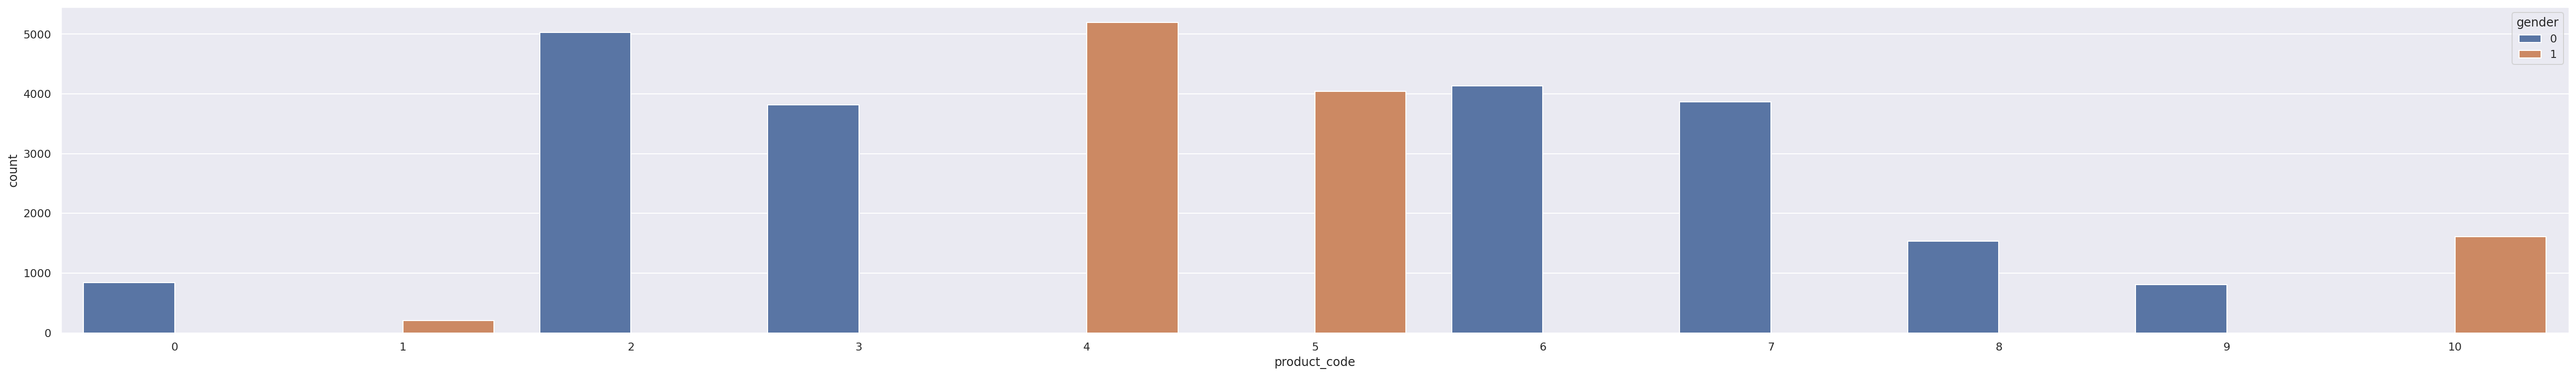

In [44]:
_, axes = plt.subplots(1, 1, sharey=True, figsize=(45, 6))
#plt.figure(figsize=(45,6))
sns.countplot(x='product_code', hue='gender', data=train );

In [45]:
train[(train['class']==0)&(train['gender']==0) ][['gender','product_type','stock_distributed']]['stock_distributed'].value_counts()

0.0     785
1.0      17
2.0       9
10.0      7
4.0       4
3.0       4
5.0       4
6.0       3
8.0       3
7.0       2
9.0       2
45.0      1
97.0      1
13.0      1
29.0      1
14.0      1
Name: stock_distributed, dtype: int64

# **after-EDA**

In [46]:
def process(df) :

  mean_0 = df[df['gender']==1]['target-1'].mean()
  
  df['gender_is_0_and_stock_is_under_mean'] =  df.apply(lambda x : 1 if x.gender==0 and x['target-1'] <  mean_0 else 0 ,axis=1)
  
  df['gender_is_0_and_class_is_3'] = df.apply(lambda x : 1 if x.gender==0 and x['class'] ==3 else 0 ,axis=1)
  
  df['gender_is_0_and_productType_is_6'] = df.apply(lambda x : 1 if x.gender==0 and x['product_type'] ==6 else 0 ,axis=1)

  df['IS_product_code_4'] = df['product_code'].apply(lambda x : 1 if x==4 else 0)
  df['IS_product_code_2'] = df['product_code'].apply(lambda x : 1 if x==2 else 0)

  return df

In [47]:
%%time
train = process(train)
test = process(test)

CPU times: user 4.83 s, sys: 91.4 ms, total: 4.92 s
Wall time: 4.93 s


In [48]:
fts = [c for c in test.columns.tolist() if c not in ['ID', 'stock_distributed', 'prediction', 'product_name']]

# **CATBOOST-GroupFold**

In [49]:
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor

oofs = np.zeros(len(train))
preds = np.zeros(len(test))
N_SPLITS = 3
folds = GroupKFold(N_SPLITS)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['year-month'], train['year-month'])):

  print(f'\n\n Fold {fold_} \\n\n')
  X_trn, y_trn = train[fts].iloc[trn_idx], target.iloc[trn_idx]
  X_val, y_val = train[fts].iloc[val_idx], target.iloc[val_idx]

  clf = CatBoostRegressor(iterations = 5000, rsm = 0.55, random_state=3, max_depth=10,
                          )

  clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], early_stopping_rounds = 150, verbose = 50)

  oofs[val_idx] = clf.predict(X_val)
  preds += clf.predict(test[fts]) / N_SPLITS



 Fold 0 \n

Learning rate set to 0.029959
0:	learn: 41.3238130	test: 38.1766167	best: 38.1766167 (0)	total: 114ms	remaining: 9m 30s
50:	learn: 31.1920220	test: 31.0377925	best: 31.0377925 (50)	total: 2.67s	remaining: 4m 18s
100:	learn: 28.3052855	test: 30.2808489	best: 30.2808489 (100)	total: 5.2s	remaining: 4m 11s
150:	learn: 26.9353638	test: 30.1760956	best: 30.1738858 (149)	total: 7.82s	remaining: 4m 11s
200:	learn: 25.9194284	test: 30.1426474	best: 30.1411528 (195)	total: 10.3s	remaining: 4m 6s
250:	learn: 24.9932224	test: 30.1932504	best: 30.1411528 (195)	total: 12.8s	remaining: 4m 2s
300:	learn: 24.2372692	test: 30.2440159	best: 30.1411528 (195)	total: 15.4s	remaining: 3m 59s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 30.14115282
bestIteration = 195

Shrink model to first 196 iterations.


 Fold 1 \n

Learning rate set to 0.029939
0:	learn: 39.5938259	test: 41.7086825	best: 41.7086825 (0)	total: 53.4ms	remaining: 4m 27s
50:	learn: 29.6393073	test: 34.521

In [50]:
ss['prediction'] = preds

In [51]:
len(preds)

3089

In [52]:
a=ss['prediction'].head(1589)*1.1
b=ss['prediction'].tail(1500)*1.27
c=a.append(b)


In [53]:
ss['prediction']=c
ss.to_csv('preds_grp_kfold.csv', index=False)

# **Feature-Importance**

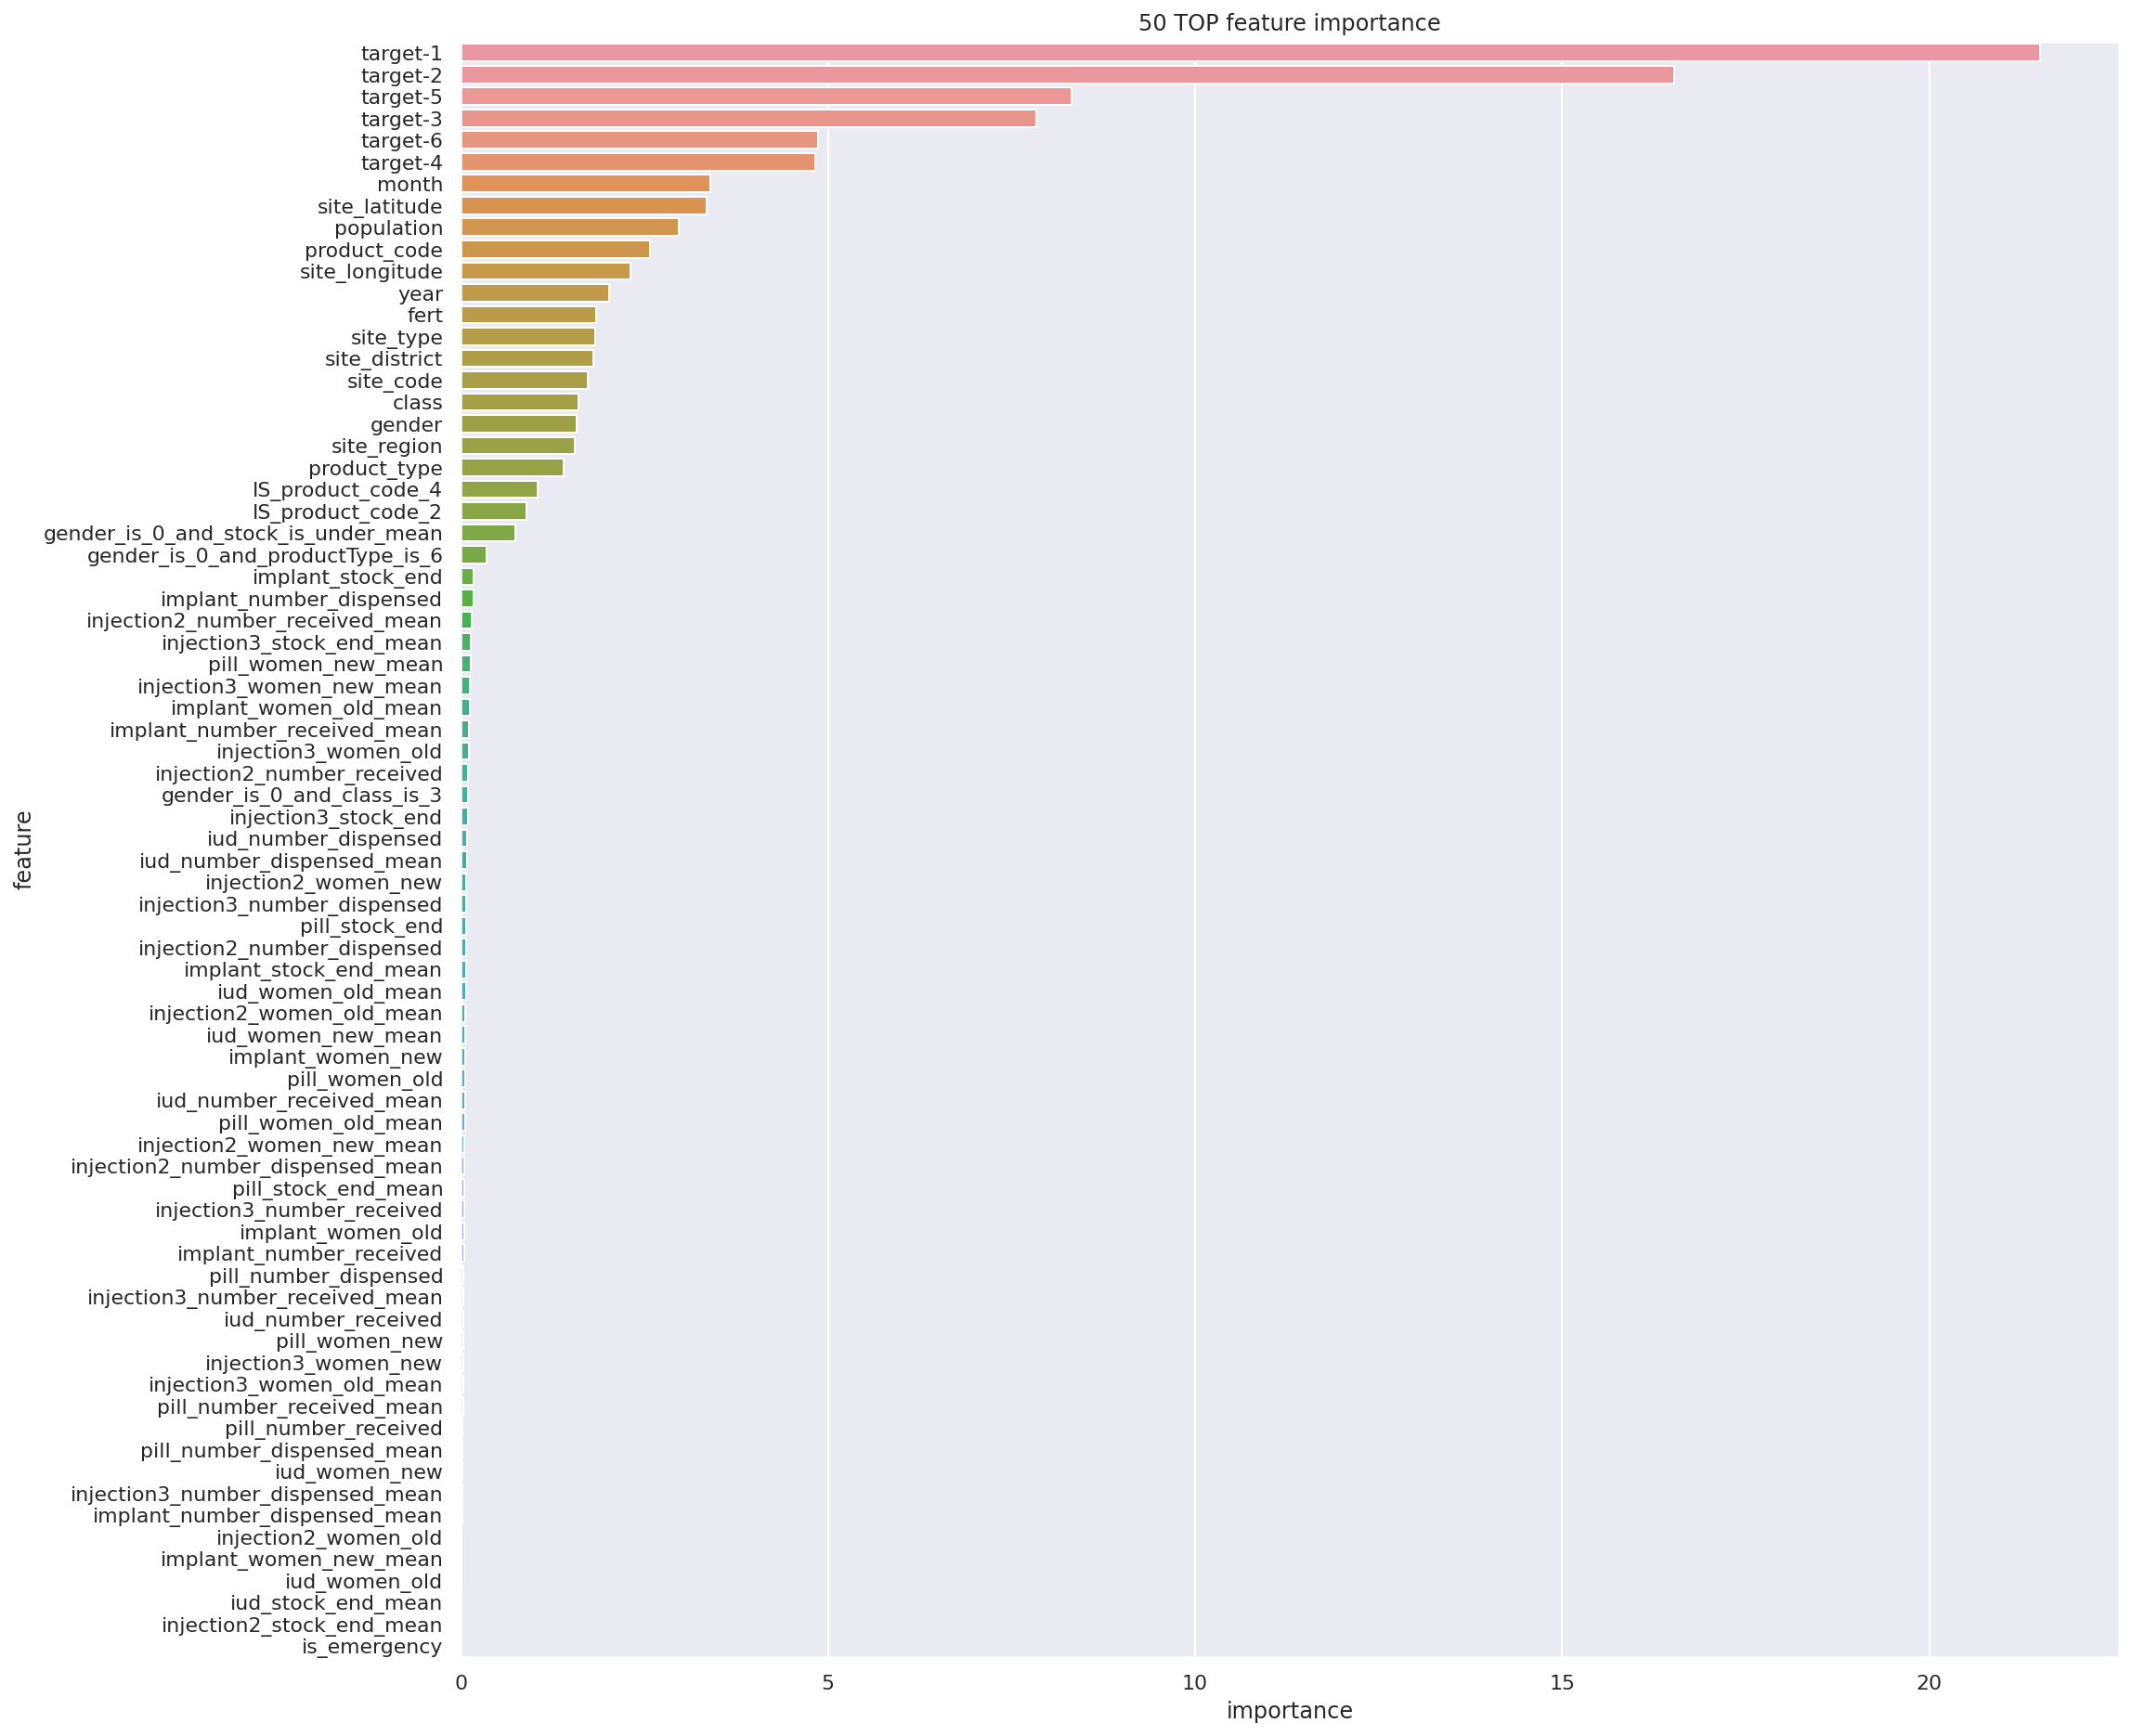

In [54]:
importance_df = pd.DataFrame()
importance_df["feature"] = fts
importance_df["importance"] = clf.get_feature_importance()
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False), x='importance', y='feature');
plt.title('50 TOP feature importance');